#### Imports & Downloads

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - TFIDF

In [2]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_tfidf()

In [3]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [4]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 6293)
y_train shape (19354,)
X_test shape (8295, 6293)
y_test shape (8295,)


### 2. Ensemble Models

In [5]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [6]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [7]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [8]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 95.71%
------------------------------------------------
Confusion Matrix:
      0    1
0  7703   51
1   305  236
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.82      0.44      0.57       541

    accuracy                           0.96      8295
   macro avg       0.89      0.71      0.77      8295
weighted avg       0.95      0.96      0.95      8295



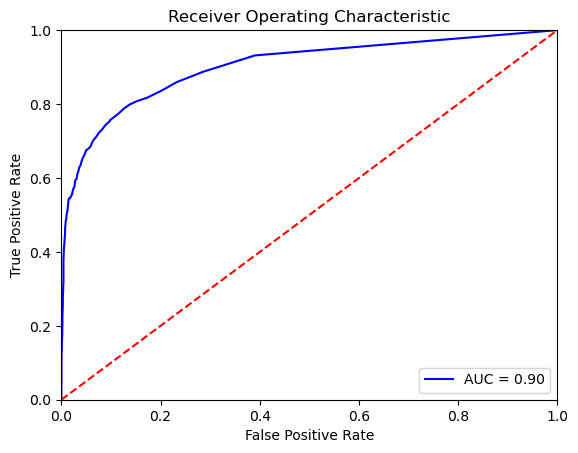

In [9]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [10]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.519) total time=  12.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV] END ................................ score: (test=0.505) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s


[CV] END ................................ score: (test=0.540) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.6s remaining:    0.0s


[CV] END ................................ score: (test=0.543) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.4s remaining:    0.0s


[CV] END ................................ score: (test=0.562) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s remaining:    0.0s


[CV] END ................................ score: (test=0.463) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   27.1s remaining:    0.0s


[CV] END ................................ score: (test=0.558) total time=   2.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   30.0s remaining:    0.0s


[CV] END ................................ score: (test=0.546) total time=   4.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   34.4s remaining:    0.0s


[CV] END ................................ score: (test=0.545) total time=   3.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.8s remaining:    0.0s


[CV] END ................................ score: (test=0.524) total time=   2.9s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   40.9s finished


In [11]:
np.mean(cv)

0.5306116784946922

###### RandomForest tuning (GridSearchCV)

In [ ]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [12]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [13]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150
[CV 1/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150;, score=0.000 total time=   0.5s
[CV 2/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150
[CV 2/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150;, score=0.000 total time=   0.4s
[CV 3/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150
[CV 3/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150;, score=0.000 total time=   0.4s
[CV 4/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150
[CV 4/5; 1/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150;, score=0.000 total time=   0.4s
[CV 5/5; 1/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=9, n_estimators=150
[CV 5/5; 1/10] END max_

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [14]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=13,
                       n_estimators=200, n_jobs=-1)


In [15]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=13,
                       n_estimators=200)

none model accuracy for classification is = 94.58%
------------------------------------------------
Confusion Matrix:
      0    1
0  7722   32
1   418  123
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.79      0.23      0.35       541

    accuracy                           0.95      8295
   macro avg       0.87      0.61      0.66      8295
weighted avg       0.94      0.95      0.93      8295



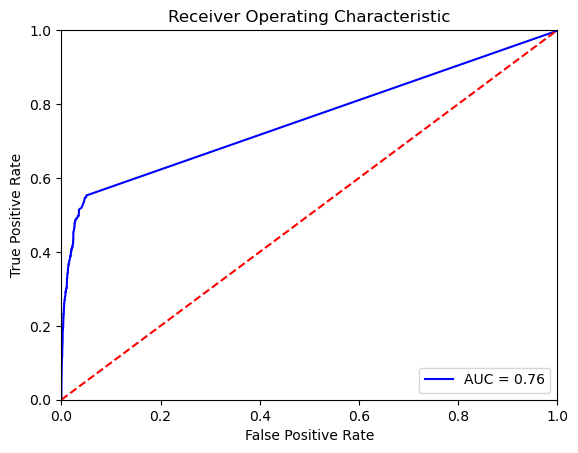

In [133]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [ ]:
# todo: überarbeiten, callback hinzufügen wie bei xgboost optuna tuning, mehr trials

In [131]:
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt'])

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

# study = optuna.create_study()
# study.optimize(objective, n_trials=5)

best_model = RandomForestClassifier(random_state=42, **study.best_params)
best_model.fit(X_train, y_train)

evaluate_model(best_model, X_test, y_test, "none")
add_to_eval_df(best_model, "RandomForestClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [17]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 88.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  6969  785
1   159  382
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7754
           1       0.33      0.71      0.45       541

    accuracy                           0.89      8295
   macro avg       0.65      0.80      0.69      8295
weighted avg       0.94      0.89      0.90      8295



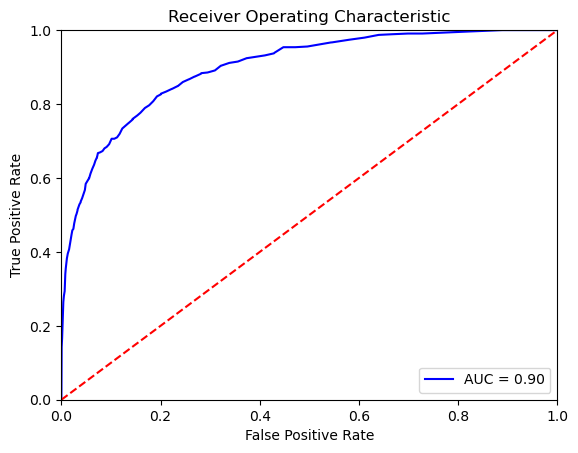

In [18]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [19]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.431) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.470) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.401) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.444) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.440) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.453) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.4s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.440) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.461) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.469) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.453) total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.5s finished


In [20]:
np.mean(cv)

0.44606878122747257

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [21]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [22]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=1)

In [23]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=6, max_leaf_nodes=13, n_estimators=250)

none model accuracy for classification is = 87.86%
------------------------------------------------
Confusion Matrix:
      0    1
0  6913  841
1   166  375
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7754
           1       0.31      0.69      0.43       541

    accuracy                           0.88      8295
   macro avg       0.64      0.79      0.68      8295
weighted avg       0.93      0.88      0.90      8295



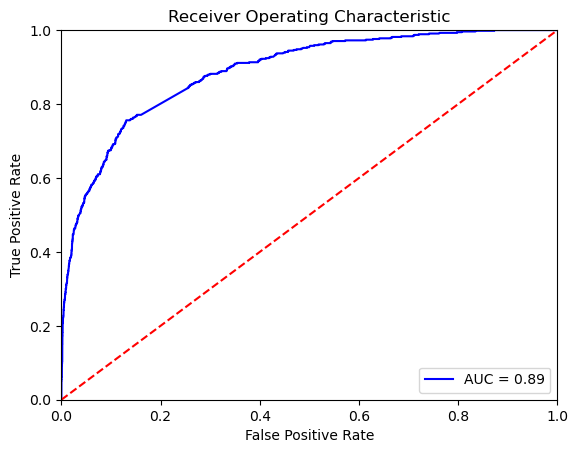

In [24]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [25]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.03%
------------------------------------------------
Confusion Matrix:
      0    1
0  7714   40
1   372  169
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.81      0.31      0.45       541

    accuracy                           0.95      8295
   macro avg       0.88      0.65      0.71      8295
weighted avg       0.94      0.95      0.94      8295



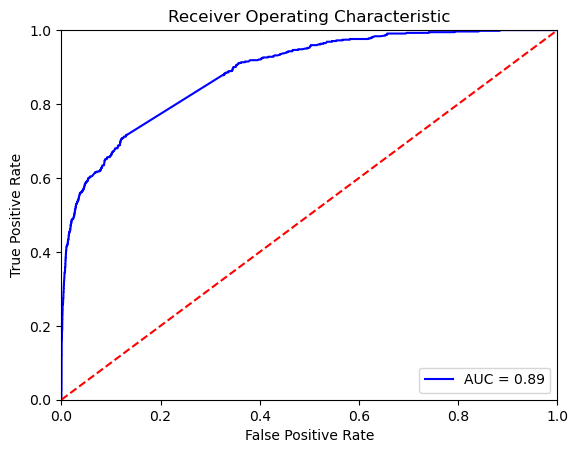

In [26]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params


In [93]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 94.85%
------------------------------------------------
Confusion Matrix:
      0    1
0  7732   22
1   405  136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.86      0.25      0.39       541

    accuracy                           0.95      8295
   macro avg       0.91      0.62      0.68      8295
weighted avg       0.94      0.95      0.94      8295



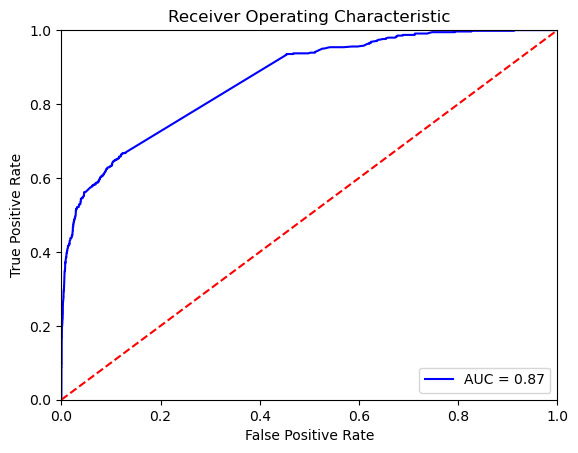

In [92]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [97]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 95.01%
------------------------------------------------
Confusion Matrix:
      0    1
0  7722   32
1   382  159
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.83      0.29      0.43       541

    accuracy                           0.95      8295
   macro avg       0.89      0.64      0.70      8295
weighted avg       0.95      0.95      0.94      8295



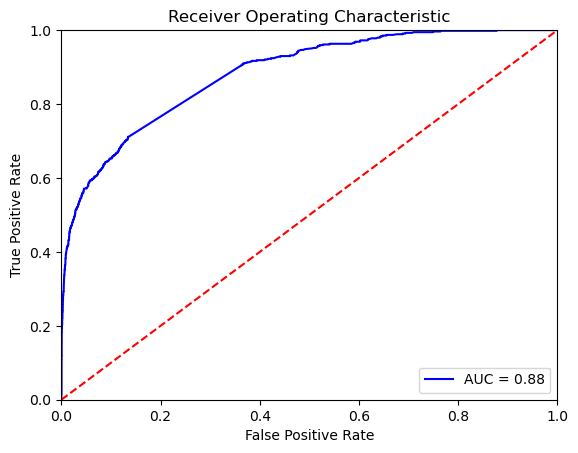

In [98]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [100]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


(0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 95.09%
------------------------------------------------
Confusion Matrix:
      0    1
0  7708   46
1   361  180
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.80      0.33      0.47       541

    accuracy                           0.95      8295
   macro avg       0.88      0.66      0.72      8295
weighted avg       0.94      0.95      0.94      8295



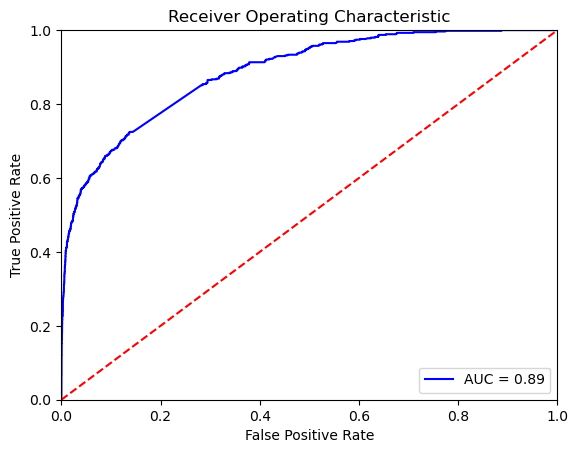

In [101]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [102]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 95.11%
------------------------------------------------
Confusion Matrix:
      0    1
0  7701   53
1   353  188
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.78      0.35      0.48       541

    accuracy                           0.95      8295
   macro avg       0.87      0.67      0.73      8295
weighted avg       0.94      0.95      0.94      8295



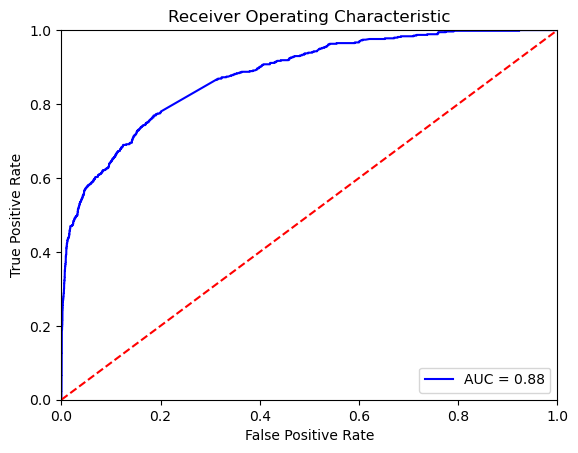

In [103]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [104]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.4406213750099548, {'min_child_weight': 1})

In [105]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.4406213750099548, {'gamma': 0.0})

In [108]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.44114103318625436, {'reg_alpha': 0.01})

In [111]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.44114103318625436, {'reg_alpha': 0.01})

In [112]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 95.07%
------------------------------------------------
Confusion Matrix:
      0    1
0  7700   54
1   355  186
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7754
           1       0.78      0.34      0.48       541

    accuracy                           0.95      8295
   macro avg       0.87      0.67      0.73      8295
weighted avg       0.94      0.95      0.94      8295



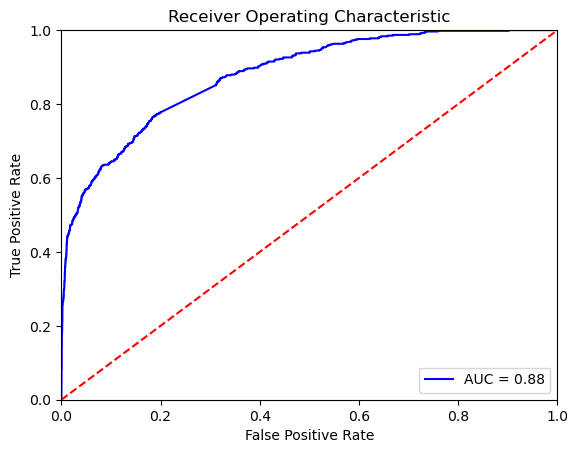

In [113]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [114]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [115]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [116]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [117]:
rsearch.best_score_, rsearch.best_params_

(0.22547782991028478,
 {'subsample': 0.5,
  'reg_alpha': 1e-05,
  'n_estimators': 100,
  'min_child_weight': 5,
  'max_depth': 5,
  'learning_rate': 0.1,
  'gamma': 0.3})

In [119]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 94.08%
------------------------------------------------
Confusion Matrix:
      0   1
0  7721  33
1   458  83
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.72      0.15      0.25       541

    accuracy                           0.94      8295
   macro avg       0.83      0.57      0.61      8295
weighted avg       0.93      0.94      0.92      8295



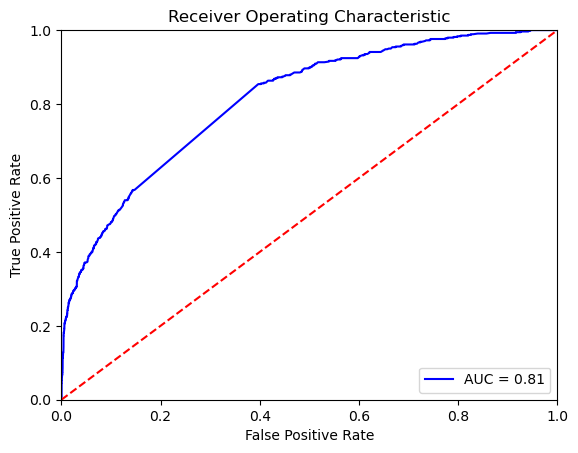

In [120]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/

https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

In [181]:
def balancedlogloss(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgb.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


In [182]:
# sampler = TPESampler(seed=42)
# pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
# study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
# study.optimize(objective, n_trials=5)

[I 2024-11-17 20:23:36,736] A new study created in memory with name: no-name-4d7e3a33-f3a1-43d0-b4d0-b682248589f3
[I 2024-11-17 20:24:18,466] Trial 0 finished with value: 0.589575 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.2935967122017216, 'colsample_bytree': 0.23485016730091968}. Best is trial 0 with value: 0.589575.
[W 2024-11-17 20:52:35,900] Trial 1 failed with parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.6994655844802531, 'colsample_bytree': 0.3274034664069657, 'max_depth': 3, 'eta': 0.0035498788321965025, 'gamma': 2.716051144654844e-06, 'grow_policy': 'depthwise'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\admin\AppData\Local\Temp\ipykernel_888

KeyboardInterrupt: 

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [41]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5864216	total: 181ms	remaining: 17.9s
1:	learn: 0.5052166	total: 219ms	remaining: 10.7s
2:	learn: 0.4412481	total: 257ms	remaining: 8.29s
3:	learn: 0.3897308	total: 295ms	remaining: 7.07s
4:	learn: 0.3509889	total: 332ms	remaining: 6.31s
5:	learn: 0.3221821	total: 370ms	remaining: 5.79s
6:	learn: 0.2974978	total: 408ms	remaining: 5.42s
7:	learn: 0.2791758	total: 447ms	remaining: 5.14s
8:	learn: 0.2652800	total: 490ms	remaining: 4.95s
9:	learn: 0.2540909	total: 530ms	remaining: 4.77s
10:	learn: 0.2452474	total: 569ms	remaining: 4.6s
11:	learn: 0.2378677	total: 608ms	remaining: 4.46s
12:	learn: 0.2315045	total: 647ms	remaining: 4.33s
13:	learn: 0.2268740	total: 688ms	remaining: 4.22s
14:	learn: 0.2226991	total: 727ms	remaining: 4.12s
15:	learn: 0.2191360	total: 765ms	remaining: 4.02s
16:	learn: 0.2163550	total: 804ms	remaining: 3.92s
17:	learn: 0.2136109	total: 843ms	remaining: 3.84s
18:	learn: 0.2112017	total: 882ms	remaining: 3.76s
19:	learn: 0.2092079	total: 922ms	remainin

none model accuracy for classification is = 94.70%
------------------------------------------------
Confusion Matrix:
      0    1
0  7740   14
1   426  115
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7754
           1       0.89      0.21      0.34       541

    accuracy                           0.95      8295
   macro avg       0.92      0.61      0.66      8295
weighted avg       0.94      0.95      0.93      8295



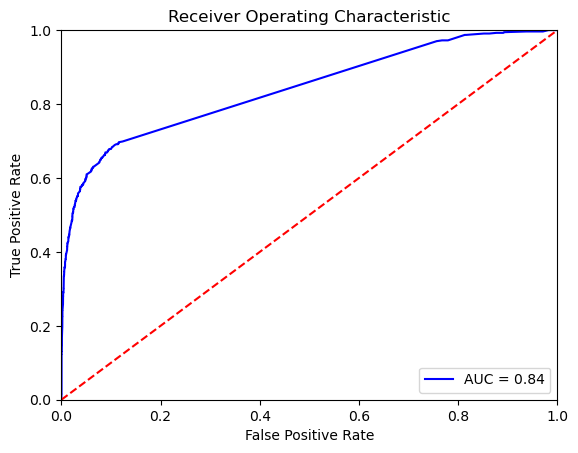

In [42]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [43]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33541
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 1210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 94.82%
------------------------------------------------
Confusion Matrix:
      0    1
0  7700   54
1   376  165
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7754
           1       0.75      0.30      0.43       541

    accuracy                           0.95      8295
   macro avg       0.85      0.65      0.70      8295
weighted avg       0.94      0.95      0.94      8295



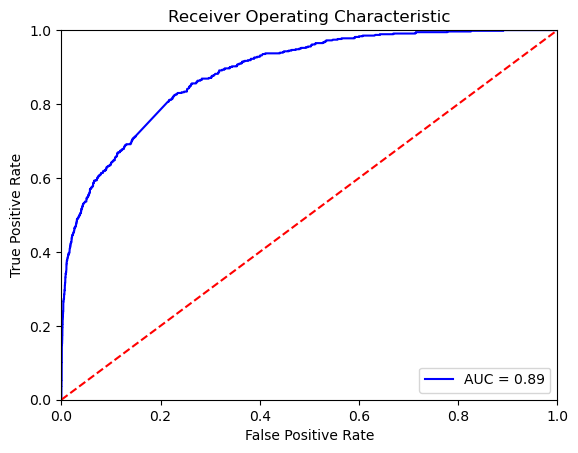

In [44]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [45]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [47]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 96.07%
------------------------------------------------
Confusion Matrix:
      0    1
0  7682   72
1   254  287
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7754
           1       0.80      0.53      0.64       541

    accuracy                           0.96      8295
   macro avg       0.88      0.76      0.81      8295
weighted avg       0.96      0.96      0.96      8295



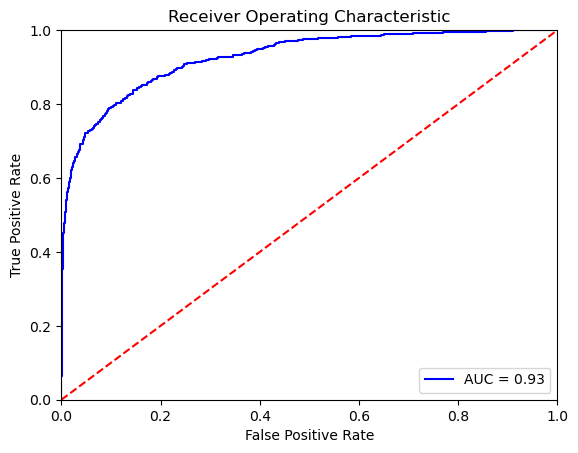

In [48]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [121]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [122]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 95.84%
------------------------------------------------
Confusion Matrix:
      0    1
0  7684   70
1   275  266
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7754
           1       0.79      0.49      0.61       541

    accuracy                           0.96      8295
   macro avg       0.88      0.74      0.79      8295
weighted avg       0.95      0.96      0.95      8295



AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [49]:
evaluation.drop_duplicates(inplace=True)

In [50]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
6,CatBoostClassifier,clean,0.947143,0.915825,0.214173,0.347160,0.946956,0.891473,0.212569,0.343284
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.957083,0.822300,0.436229,0.570048
4,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
8,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
1,RandomForestClassifier-tuned,clean,0.944869,0.787535,0.218898,0.342575,0.945750,0.793548,0.227357,0.353448
5,XGBClassifier-tuned,clean,0.957218,0.916981,0.382677,0.540000,0.949488,0.790476,0.306839,0.442077
7,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
2,BalancedRandomForestClassifier,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307
3,BalancedRandomForestClassifier-tuned,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307


In [51]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307
3,BalancedRandomForestClassifier-tuned,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307
8,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.957083,0.822300,0.436229,0.570048
4,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
5,XGBClassifier-tuned,clean,0.957218,0.916981,0.382677,0.540000,0.949488,0.790476,0.306839,0.442077
7,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
1,RandomForestClassifier-tuned,clean,0.944869,0.787535,0.218898,0.342575,0.945750,0.793548,0.227357,0.353448
6,CatBoostClassifier,clean,0.947143,0.915825,0.214173,0.347160,0.946956,0.891473,0.212569,0.343284


In [52]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
8,StackingClassifier,clean,0.995040,0.988353,0.935433,0.961165,0.960699,0.799443,0.530499,0.637778
0,RandomForestClassifier,clean,0.999948,1.000000,0.999213,0.999606,0.957083,0.822300,0.436229,0.570048
4,XGBClassifier,clean,0.959750,0.922547,0.422047,0.579146,0.950332,0.808612,0.312384,0.450667
2,BalancedRandomForestClassifier,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307
3,BalancedRandomForestClassifier-tuned,clean,0.909993,0.421647,1.000000,0.593181,0.886197,0.327335,0.706100,0.447307
5,XGBClassifier-tuned,clean,0.957218,0.916981,0.382677,0.540000,0.949488,0.790476,0.306839,0.442077
7,LGBMClassifier,clean,0.961713,0.927302,0.451969,0.607729,0.948162,0.753425,0.304991,0.434211
1,RandomForestClassifier-tuned,clean,0.944869,0.787535,0.218898,0.342575,0.945750,0.793548,0.227357,0.353448
6,CatBoostClassifier,clean,0.947143,0.915825,0.214173,0.347160,0.946956,0.891473,0.212569,0.343284


none model accuracy for classification is = 95.71%
------------------------------------------------
Confusion Matrix:
      0    1
0  7703   51
1   305  236
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7754
           1       0.82      0.44      0.57       541

    accuracy                           0.96      8295
   macro avg       0.89      0.71      0.77      8295
weighted avg       0.95      0.96      0.95      8295



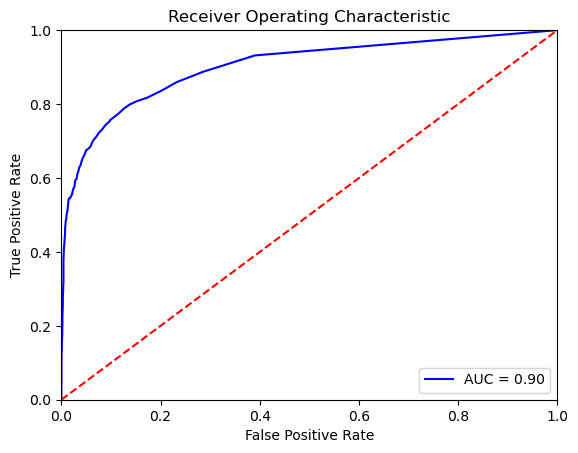

In [53]:
evaluate_model(rf, X_test, y_test, "none")

#### Auswertung

- Modelle, die eine gute Precision erzielen, haben einen schlechten Recall => die getroffenen Vorhersagen sind gut, allerdings werden nicht viele korrekt vorhergesagt (wenige true positives)
- Modelle, die einen guten Recall erzielen, haben einen schlechten Recall => es werden mehr korrekt vorhergesagt, allerdings bei allgemein schlechteren Vorhersagen (mehr false positives)
- deutlich erkennbar am f1 score => Modelle mit bester Precision/Recall mit schlechtem f1 score
- o.g. Punkte sowohl in Train als auch Test zu sehen
- bestes Modell: RandomForest ohne Tuning => ca. 81% Precision und 43% Recall bei Test, bei Train ~99%; cross validation (10) führt zu f1 von ~52%
- Performance RF deutet auf Overfitting hin, mittels RandomizedSearchCV jedoch kein Modell mit geringerer Train aber besserer Test Performance erreichbar (gilt auch für BalancedRandomForestClassifier)


Zielmetrik: F1-Score

XGBClassifier: GridSearch vs. RandomizedSearch
- Grid deutlich besser

StackingClassifier
- erzielt leicht bessere Ergebnisse als das beste Einzelmodell (SVC mit 61%, gestackt mit RandomForest 64%)